In [1]:
import os
import torch
import numpy as np
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [2]:
### ===== Hyperparameters ===== ###

mdl_name = 'vae2'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001

seed_load = np.random.randint(0,999999999)
seed_model = np.random.randint(0,999999999)
device = trn.get_device()

In [3]:
def get_map_offset(instru2corpus, instrument):
    Corpus = []
    for num in range(len(instru2corpus[instrument])):
        song = np.array([float(off[1]) for off in np.array(instru2corpus[instrument][num])])
        song = song[1:]-song[:-1]
        Corpus += list([round(off,2) for off in song])+[1]
    Corpus = list(set(Corpus))
    
    fmap, rmap = {}, {}
    for idx, key in enumerate(sorted(Corpus)):
        fmap[key] = idx
        rmap[idx] = key
    return Corpus, fmap, rmap

In [4]:
### ===== Data Preprocessing ===== ###

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
Corpus2, fmap2, rmap2 = get_map_offset(instru2corpus, instrument)
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short
X_train, X_val = pcr.train_test_split_joint(instru2corpus, instrument, fmap, song_len, stride, seed=seed_load, process='difference')
X_train, X_val = pcr.batchify_joint(X_train), pcr.batchify_joint(X_val) # reshape and turn into tensor

classes1 = len(set(Corpus)) # get number of unique keys
classes2 = len(Corpus2)

In [5]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

class cnn_varencoder(nn.Module):
    def __init__(self, inp_channel, mult):
        super(cnn_varencoder, self).__init__()
        
        self.conv1 = nn.Conv1d(inp_channel, 16, 21, 1, 0)
        self.conv21 = nn.Conv1d(16, 4, 11, 1, 0)
        self.conv22 = nn.Conv1d(16, 4, 11, 1, 0)
        self.pool = nn.MaxPool1d(2,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        self.linear = nn.Linear(160+200*(mult-1), 20)
        
    def forward(self, I):
        h = self.pool(self.relu(self.conv1(I)))
        h1, h2 = self.pool(self.relu(self.conv21(h))), self.pool(self.relu(self.conv22(h)))
        h1, h2 = self.linear(self.flat(h1)), self.linear(self.flat(h2))
        return h1, h2
    
class cnn_vardecoder(nn.Module):
    def __init__(self, inp_channel, mult, p=0):
        super(cnn_vardecoder, self).__init__()        
        self.tconv1 = nn.ConvTranspose1d(4, 16, 11, 1, 0)
        self.tconv2 = nn.ConvTranspose1d(16, inp_channel, 31, 1, 0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(20, (160+200*(mult-1))*4)
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, z):
        h = self.relu(self.linear(z))
        h = h.view(1,4,-1)
        h = self.relu(self.tconv1(h))
        h = self.tconv2(h)
        h = self.dropout(h)
        return h
    
class cnn_varautoencoder(nn.Module):
    def __init__(self, inp_channel, mult, classes, classes2, std=1.0, p=0):
        super(cnn_varautoencoder, self).__init__()
        self.encoder = cnn_varencoder(inp_channel, mult)
        self.decoder = cnn_vardecoder(inp_channel, mult, p=p)
        self.use_var = False
        self.mu = None
        self.var = None
        self.mult = mult
        self.classes1 = classes1
        self.classes2 = classes2
        self.std = std
        
    def reparameterize(self, mu, logvar):
        '''mu: mean matrix. logvar: variance matrix.'''
        if self.training or self.use_var:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:       
            return mu
        
    def get_prob(self, y, classes):
        mu = y.squeeze()
        norm = Normal(mu, torch.tensor([self.std]))
        x = torch.arange(classes).expand(200*self.mult, classes)
        x = torch.transpose(x, 0, 1)
        prob = norm.log_prob(x) #.exp()
        prob = torch.transpose(prob, 0, 1)
        return prob
        
    def forward(self, I):
        mu, logvar = self.encoder(I)
        z = self.reparameterize(mu, logvar)
        z = z.view(1,1,-1)
        y = self.decoder(z)
        y1, y2 = y.squeeze()
        prob1 = self.get_prob(y1, self.classes1)
        prob2 = self.get_prob(y1, self.classes2)
        return y1, y2, mu, logvar, prob1, prob2

In [6]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1, lda2=1, lda3=0, lda4=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False, mdl_load=''):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_load, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1
    if type(lda2) != np.ndarray: lda2 = np.ones(epochs)*lda2
    if type(lda3) != np.ndarray: lda3 = np.ones(epochs)*lda3
    if type(lda4) != np.ndarray: lda4 = np.ones(epochs)*lda4

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recons1, recons2, mu, logvar, prob1, prob2 = model(batch_data)
            
            # calculate loss
            batch1, batch2 = batch_data.squeeze()
            l = lda0[e]*criterion1(recons1, batch1) + lda1[e]*criterion2(prob1, batch1.long())\
                + lda2[e]*trn.KL(mu, logvar) + lda3[e]*criterion1(recons2, batch2) + lda4[e]*criterion2(prob2, batch2.long())
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        acc1 = trn.accuracy(recons1.view(-1), batch1.view(-1))
        acc2 = trn.accuracy(recons2.view(-1), batch2.view(-1))
        train_losses.append(np.mean(batch_losses))
        train_acc.append(np.mean([acc1, acc2]))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons1, recons2, mu, logvar, prob1, prob2 = model(batch_data)
            
            # calculate loss
            batch1, batch2 = batch_data.squeeze()
            l = lda0[e]*criterion1(recons1, batch1) + lda1[e]*criterion2(prob1, batch1.long())\
                + lda2[e]*trn.KL(mu, logvar) + lda3[e]*criterion1(recons2, batch2) + lda4[e]*criterion2(prob2, batch2.long())
            batch_losses.append(l.item())
            
        acc1 = trn.accuracy(recons1.view(-1), batch1.view(-1))
        acc2 = trn.accuracy(recons2.view(-1), batch2.view(-1))
        val_losses.append(np.mean(batch_losses))
        val_acc.append(np.mean([acc1, acc2]))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

Epoch: 0	 TLoss: 2381.468367	 VLoss: 1557.060084	 TACC: 0.46	 VACC: 0.46
Epoch: 100	 TLoss: 102.243336	 VLoss: 96.813511	 TACC: 0.50	 VACC: 0.48
Epoch: 200	 TLoss: 106.167702	 VLoss: 96.815792	 TACC: 0.51	 VACC: 0.47
Epoch: 300	 TLoss: 103.161276	 VLoss: 97.074847	 TACC: 0.51	 VACC: 0.48
Epoch: 400	 TLoss: 102.434734	 VLoss: 97.904829	 TACC: 0.50	 VACC: 0.47
Epoch: 500	 TLoss: 102.129282	 VLoss: 97.024866	 TACC: 0.50	 VACC: 0.47
Epoch: 600	 TLoss: 102.158642	 VLoss: 96.995863	 TACC: 0.50	 VACC: 0.47
Epoch: 700	 TLoss: 102.412111	 VLoss: 96.960077	 TACC: 0.50	 VACC: 0.48
Epoch: 800	 TLoss: 103.019828	 VLoss: 98.087274	 TACC: 0.51	 VACC: 0.48
Epoch: 900	 TLoss: 106.092432	 VLoss: 100.986926	 TACC: 0.50	 VACC: 0.48
Epoch: 1000	 TLoss: 115.730111	 VLoss: 110.591858	 TACC: 0.50	 VACC: 0.47
Epoch: 1100	 TLoss: 148.519191	 VLoss: 142.991865	 TACC: 0.51	 VACC: 0.47
Epoch: 1200	 TLoss: 259.133202	 VLoss: 250.534687	 TACC: 0.50	 VACC: 0.47
Epoch: 1300	 TLoss: 604.964587	 VLoss: 585.949404	 TACC:

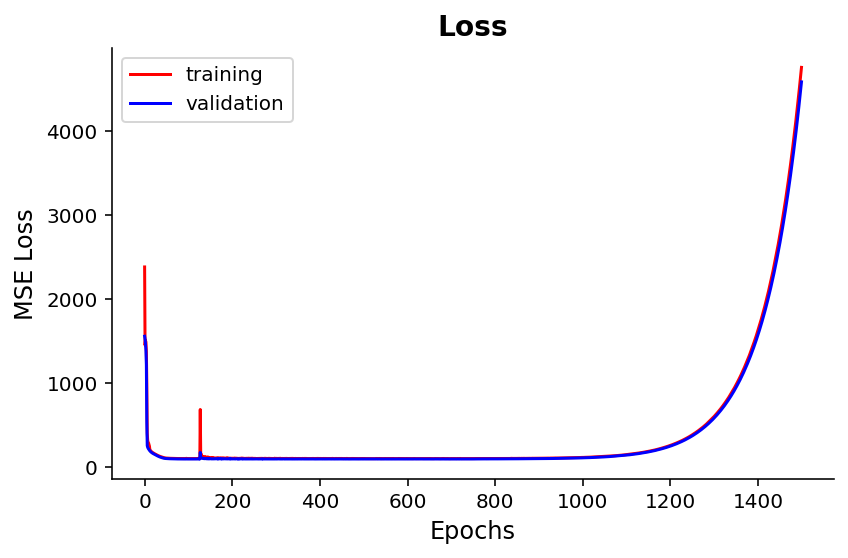

<Figure size 432x288 with 0 Axes>

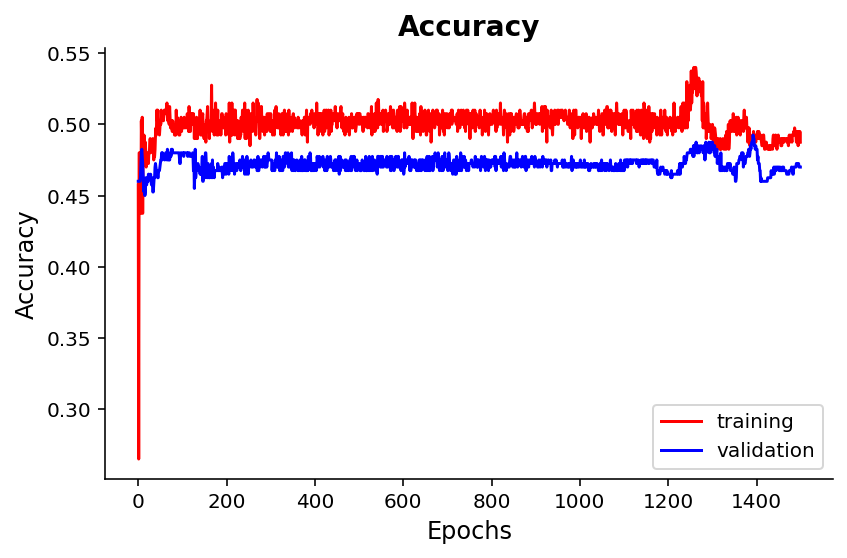

<Figure size 432x288 with 0 Axes>

In [17]:
### ===== Train Model for Melody using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = cnn_varautoencoder(2, song_len//200, classes1, classes2, std=0.1)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.ones(750), np.geomspace(1,0.01,750)) #np.ones(1500)*0.01
    lda = np.append(np.zeros(750)*0.0001, np.ones(750)*0.001)
    model_m, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name+'_difference',
               X_train, X_val,
               learning_rate, [seed_load, seed_model], 1500,
               eepoch=100,
               lda0=1, lda1=lda, lda2=0.001, lda3=1, lda4=lda,
               stdlog=stdlog,
               train_losses=[], val_losses=[], train_acc=[], val_acc=[],
               save=True, load=False)
    
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/vae2_difference_loss.png', ylabel='MSE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/vae2_difference_acc.png', ylabel='Accuracy', title='Accuracy')
    
except KeyboardInterrupt:
    print('Training terminated.')

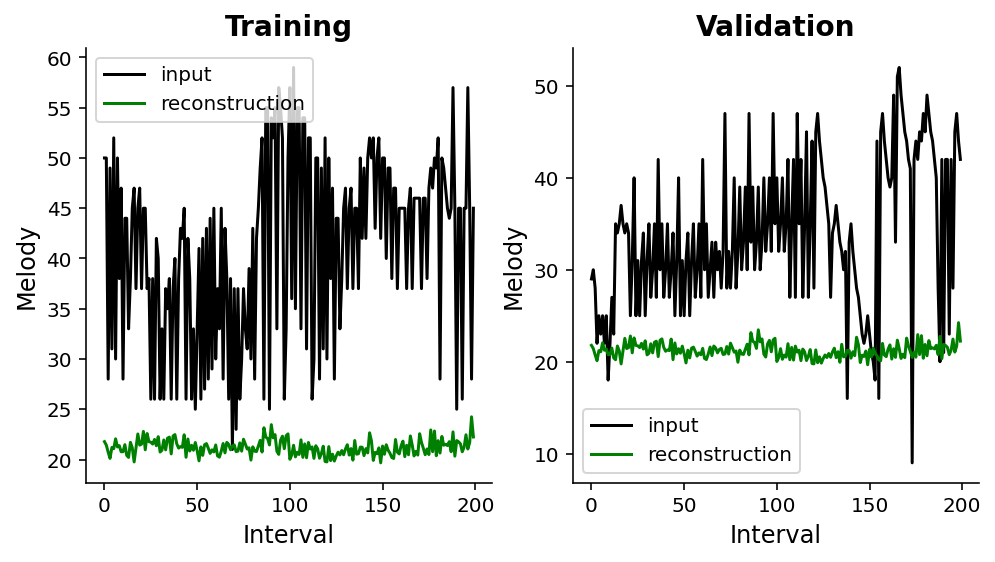

In [18]:
import matplotlib.pyplot as plt

sample_train1, sample_train2 = X_train[0].squeeze()
sample_val1, sample_val2 = X_val[0].squeeze()

model = cnn_varautoencoder(2, song_len//200, classes1, classes2, std=0.1)
model.float()
model = trn.load_model('vae2_difference', model, device)[0]
model.eval()
recons_train1, recons_train2 = model(X_train[0])[:2]
recons_val1, recons_val2 = model(X_val[0])[:2]

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(sample_train1.view(-1), 'k', label='input')
ax1.plot(recons_train1.detach().numpy().reshape(-1), 'g', label='reconstruction')
ax2.plot(sample_val1.view(-1), 'k', label='input')
ax2.plot(recons_val1.detach().numpy().reshape(-1), 'g', label='reconstruction')

ax1.set_xlabel('Interval', fontsize=12); ax1.set_ylabel('Melody', fontsize=12)
ax1.set_title('Training', fontsize=14, fontweight='bold'); ax1.legend()
ax2.set_xlabel('Interval', fontsize=12); ax2.set_ylabel('Melody', fontsize=12)
ax2.set_title('Validation', fontsize=14, fontweight='bold'); ax2.legend()

ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

plt.savefig('vae2_melody.png', dpi=300)

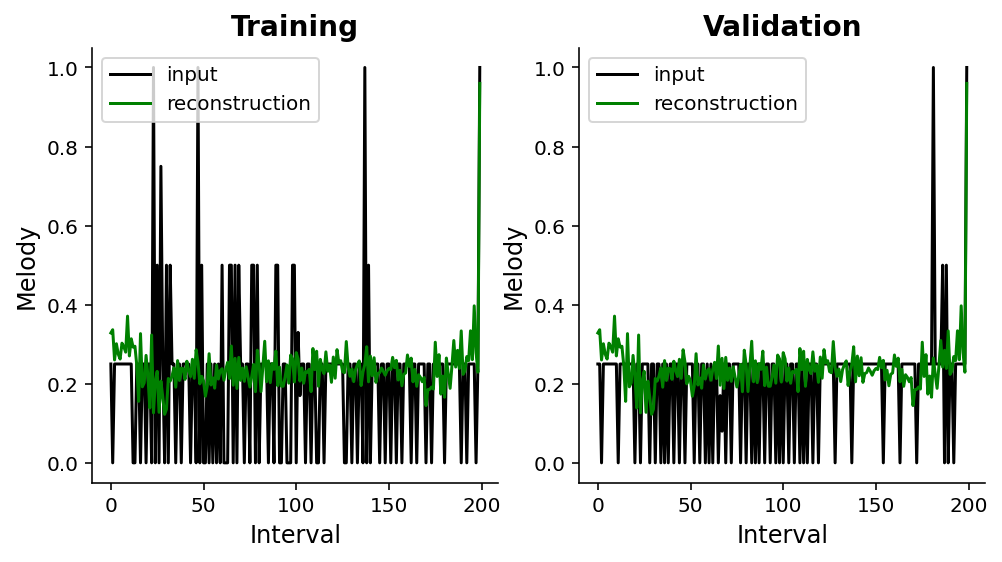

In [14]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(sample_train2.view(-1), 'k', label='input')
ax1.plot(recons_train2.detach().numpy().reshape(-1), 'g', label='reconstruction')
ax2.plot(sample_val2.view(-1), 'k', label='input')
ax2.plot(recons_val2.detach().numpy().reshape(-1), 'g', label='reconstruction')

ax1.set_xlabel('Interval', fontsize=12); ax1.set_ylabel('Melody', fontsize=12)
ax1.set_title('Training', fontsize=14, fontweight='bold'); ax1.legend()
ax2.set_xlabel('Interval', fontsize=12); ax2.set_ylabel('Melody', fontsize=12)
ax2.set_title('Validation', fontsize=14, fontweight='bold'); ax2.legend()

ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

plt.savefig('vae2_offset.png', dpi=300)

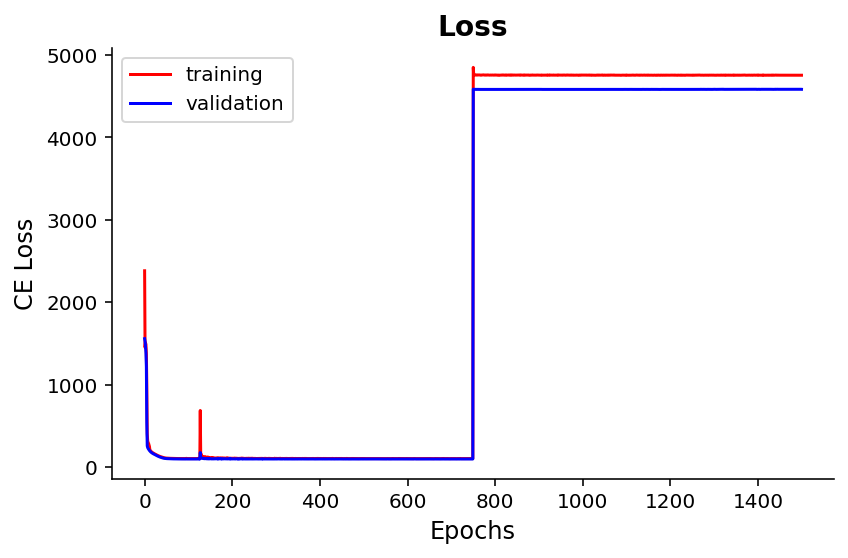

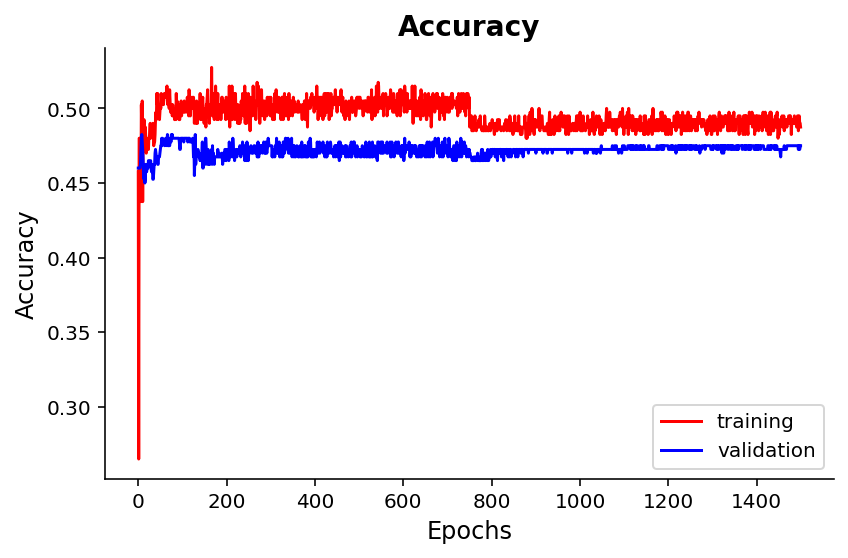

In [16]:
vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_loss.png'.format(mdl_name), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_acc.png'.format(mdl_name), ylabel='Accuracy', title='Accuracy', show=False)